# Datamining
## Assignment 2 - Exercise 3


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets as sk_data

Read .json files as a file stream and keep only useful info.

In [2]:
businesses = []
with open('yelp_academic_dataset_business.json',encoding="utf8") as f:
    for line in f:
        cat = line.find("\"categories\"")
        catEnd = line.find("\"hours\"")
        cat = line[cat+2+len("\"categories\""):catEnd-2].replace(" ","")
        cat = cat.split(",")

        beauty = "Beauty&Spas" in cat
        shopping = "Shopping" in cat
        bar = "Bars" in cat
        if(line.find("Toronto") != -1 and (beauty or shopping or bar)):
            categories = []
            #Assign biz category according to priority list
            if(beauty):
                categories = "Beauty & Spas"
            elif(shopping):
                categories = "Shopping"
            elif(bar):
                categories = "Bars"
       
            bizReviewCount = line.split("\"review_count\"")[1].split(",")[0][1:]
            if(int(bizReviewCount) >= 10):
                bizID = line.split("\"business_id\"")[1].split(",")[0][2:-1]
                bizDataToKeep = [bizID,categories,""]
                businesses.append(bizDataToKeep)
f.close()

Create a dataframe for the businesses so we can later add review text and tf-idf.

In [3]:
df = pd.DataFrame(businesses,columns=["business_id","categories","review"])
bizIDList = list(df.business_id)
torontoBiz = {}
for i in bizIDList:
    torontoBiz[i] = 1
del bizIDList
df

business_id     categories review
0     cicPsia8Wj-DNRkmLbD_xg           Bars       
1     xVXyrTWbG8U3szze-aA7eg           Bars       
2     e-tRKAC-q40SqQfAOwYa-A  Beauty & Spas       
3     C9keC4mWuXdl2mYFHZXudQ       Shopping       
4     PFS9kf3U-ZCvpqay3AaNnQ       Shopping       
...                      ...            ...    ...
3003  Cesnh6fIsAUO8D4jfGhOIw       Shopping       
3004  lkq6i2x3vUsR7ZNrIFqoIw           Bars       
3005  wjqOdj0XJUDOOtU9LjRlWQ           Bars       
3006  AqpB2IoLkUupDCuH-hmVdg       Shopping       
3007  0hudPyuCBlKg79OwKBw-eQ           Bars       

[3008 rows x 3 columns]

Get only toronto reviews.

In [4]:
with open('yelp_academic_dataset_review.json',encoding="utf8") as f:
    count = 0
    lines = f.readlines(1)

    while lines:
        line = lines[0]
        bizID = line.split("\"business_id\"")[1].split(",")[0][2:-1]
        if(torontoBiz.get(bizID) == 1):
            text = line.find("\"text\"")
            textEnd = line.find("\"date\"")
            text = line[text+2+len("\"text\""):textEnd-2].replace("\\n","")
            m = df.index[df['business_id'] == bizID].tolist()[0]
            df.loc[m]["review"] += text   
        lines = f.readlines(1)

## TF-IDF

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
v = TfidfVectorizer(stop_words = 'english',min_df=4, max_df=0.8)
data = v.fit_transform(df.review)

v.get_feature_names() will give you the list of feature names. v.vocabulary_ will give you a dict with feature names as keys and their index in the matrix produced as values.

In [6]:
#v.vocabulary_

In [7]:
#code for cluster class mapping taken from lab 4 notebook
def cluster_class_mapping(kmeans_labels,true_labels):
    C= metrics.confusion_matrix(kmeans_labels,true_labels)
    mapping = list(np.argmax(C,axis=1))
    mapped_kmeans_labels = [mapping[l] for l in kmeans_labels]
    C2= metrics.confusion_matrix(mapped_kmeans_labels,true_labels)
    return mapped_kmeans_labels,C2

### K-Means clustering and metrics.

In [8]:
import sklearn.cluster as sk_cluster
k=3
kmeans = sk_cluster.KMeans(n_clusters=k, init='k-means++', max_iter=100,n_init=1)
kmeans.fit_predict(data)

array([2, 2, 1, ..., 1, 1, 2])

In [9]:
kmeans1 = kmeans

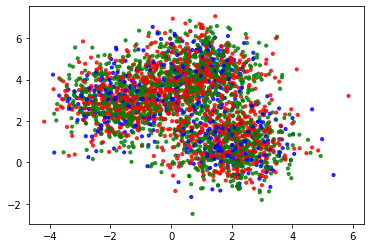

In [10]:
X, true_labels = sk_data.make_blobs(n_samples=3008, centers=3, n_features=2,
center_box=(-10.0, 10.0),random_state=0)
colors = np.array([x for x in 'bgrcmykbgrcmykbgrcmykbgrcmyk'])
colors = np.hstack([colors] * 20)
plt.scatter(X[:, 0], X[:, 1], color=colors[kmeans.labels_].tolist(), s=10,alpha=0.8)

In [11]:
print("Top terms per cluster:")
asc_order_centroids = kmeans.cluster_centers_.argsort()#[:, ::-1]
order_centroids = asc_order_centroids[:,::-1]
terms = v.get_feature_names()
for i in range(k):
    print ("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print (' %s' % terms[ind])
    print

Top terms per cluster:
Cluster 0:
 hair
 nails
 salon
 nail
 cut
 shellac
 manicure
 haircut
 stylist
 pedicure
Cluster 1:
 store
 massage
 shop
 customer
 bike
 buy
 selection
 location
 stores
 items
Cluster 2:
 food
 bar
 menu
 beer
 drinks
 ordered
 restaurant
 chicken
 night
 patio


We can see that the top words of each cluster very roughly correlate to our categories: Beauty&Spas, Shopping, Bars

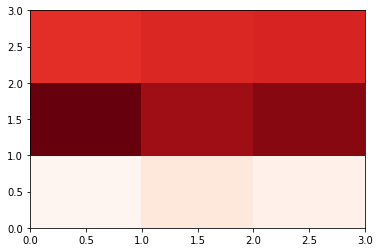

In [12]:
import sklearn.metrics as metrics
C = metrics.confusion_matrix(kmeans.labels_,true_labels)
plt.pcolormesh(C,cmap=plt.cm.Reds)

In [13]:
mapped_kmeans_labels,C = cluster_class_mapping(kmeans.labels_,true_labels)

In [14]:
p = metrics.precision_score(true_labels,kmeans.labels_, average=None)
print(p)
r = metrics.recall_score(true_labels,kmeans.labels_, average = None)
print(r)    

[0.30705394 0.32060519 0.33831283]
[0.14755733 0.44366899 0.38423154]


We have pretty bad clustering metrics and that means that we have bad clustering, we will seek to improve it later by changing the amount of clusters.

### Agglomerative clustering and metrics.

Complete linkage

0.23441766637435188
0.3464095744680851


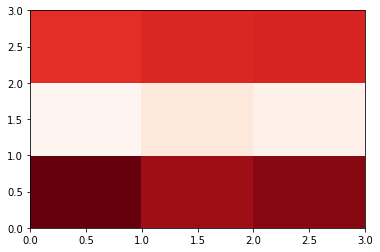

In [15]:
import scipy.cluster.hierarchy as hr
agglo = sk_cluster.AgglomerativeClustering(linkage = 'complete', n_clusters = 3)
dense_data = data.toarray()
agglo_labels = agglo.fit_predict(dense_data)
C_agglo= metrics.confusion_matrix(agglo_labels,true_labels)
mapped_agglo_labels,C_agglo = cluster_class_mapping(agglo_labels,true_labels)
p = metrics.precision_score(true_labels,mapped_agglo_labels, average='weighted')
print(p)
r = metrics.recall_score(true_labels,mapped_agglo_labels, average = 'weighted')
print(r)
plt.pcolormesh(C,cmap=plt.cm.Reds)

Cluster metrics have at most remained the same, if not worsened, this means that the cluster method is less suitable than kmeans.

Complete-Link will merge two clusters when all pair of elements are linked. As our tf-idf of the reviews contains typers of businesses, it is impossible to link all clusters togerther, but it is possible to link similar types of tfidf, meaning that it will merge businesses with similar results thus merging the businesses of the same category. We can see that there are 3 clusters in the figure below, the same as our categories.


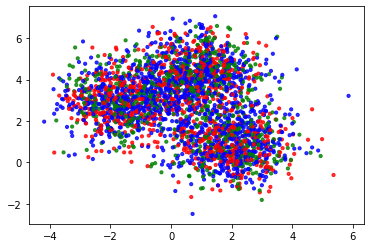

In [16]:
plt.scatter(X[:, 0], X[:, 1], color=colors[agglo_labels].tolist(), s=10,alpha=0.8)

Single Linkage

0.4447031247788112
0.3341090425531915


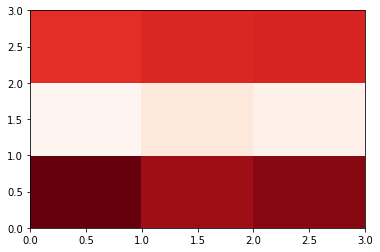

In [17]:
agglo = sk_cluster.AgglomerativeClustering(linkage = 'single', n_clusters = 3)
dense_data = data.toarray()
agglo_labels = agglo.fit_predict(dense_data)
C_agglo= metrics.confusion_matrix(agglo_labels,true_labels)
mapped_agglo_labels,C_agglo = cluster_class_mapping(agglo_labels,true_labels)
p = metrics.precision_score(true_labels,mapped_agglo_labels, average='weighted')
print(p)
r = metrics.recall_score(true_labels,mapped_agglo_labels, average = 'weighted')
print(r)
plt.pcolormesh(C,cmap=plt.cm.Reds)

Cluster metrics have increased, this means that the cluster method is better and more suitable than kmeans.

Single-Link will merge two clusters when a single pair of elements is linked. As our tf-idf of the reviews contains many shared words it is possible that it will merge all clusters into one as we can see in the figure below. 


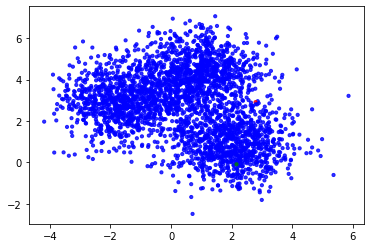

In [18]:
plt.scatter(X[:, 0], X[:, 1], color=colors[agglo_labels].tolist(), s=10,alpha=0.8)

Average Linkage

0.44466612478684486
0.3337765957446808


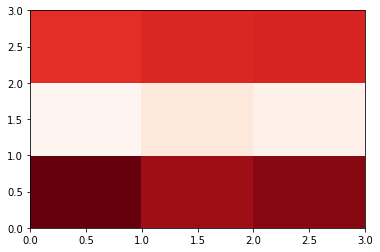

In [19]:
agglo = sk_cluster.AgglomerativeClustering(linkage = 'average', n_clusters = 3)
dense_data = data.toarray()
agglo_labels = agglo.fit_predict(dense_data)
C_agglo= metrics.confusion_matrix(agglo_labels,true_labels)
mapped_agglo_labels,C_agglo = cluster_class_mapping(agglo_labels,true_labels)
p = metrics.precision_score(true_labels,mapped_agglo_labels, average='weighted')
print(p)
r = metrics.recall_score(true_labels,mapped_agglo_labels, average = 'weighted')
print(r)
plt.pcolormesh(C,cmap=plt.cm.Reds)

Cluster metrics are the same as single-link as it almost merges all clusters.

Average method merges clusters with same average distance. We have tf-idf of reviews, meaning that most words will be the same, except the words that correlate to a specific category of business such as: "nails","spa","beer","waitress" etc.. We can expect all clusters to be merged , except maybe some truly unique reviews, as most words will be the same or similar. 

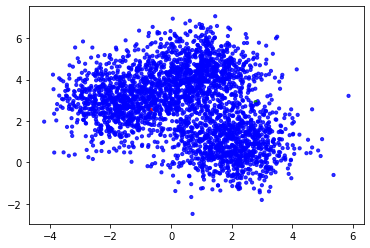

In [20]:
plt.scatter(X[:, 0], X[:, 1], color=colors[agglo_labels].tolist(), s=10,alpha=0.8)

Ward Linkage

0.22891155001138405
0.34341755319148937


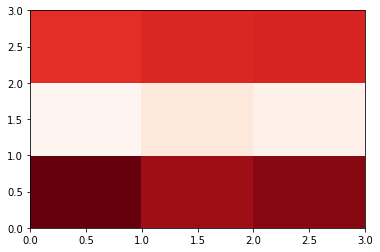

In [21]:
agglo = sk_cluster.AgglomerativeClustering(linkage = 'ward', n_clusters = 3)
dense_data = data.toarray()
agglo_labels = agglo.fit_predict(dense_data)
C_agglo= metrics.confusion_matrix(agglo_labels,true_labels)
mapped_agglo_labels,C_agglo = cluster_class_mapping(agglo_labels,true_labels)
p = metrics.precision_score(true_labels,mapped_agglo_labels, average='weighted')
print(p)
r = metrics.recall_score(true_labels,mapped_agglo_labels, average = 'weighted')
print(r)
plt.pcolormesh(C,cmap=plt.cm.Reds)

Ward’s Method uses squared error to merge together clusters.

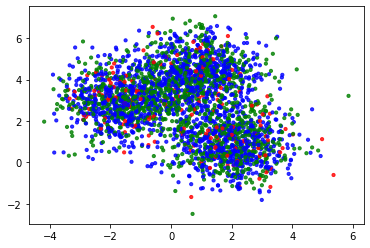

In [22]:
plt.scatter(X[:, 0], X[:, 1], color=colors[agglo_labels].tolist(), s=10,alpha=0.8)

Cluster metrics are the worst using the ward hierarhical method.

### K-Means, estimating the "right" amount of clusters using SSE curve and silhouette plot.

Silhouette plot of error per number of clusters.

Text(0, 0.5, 'Error')

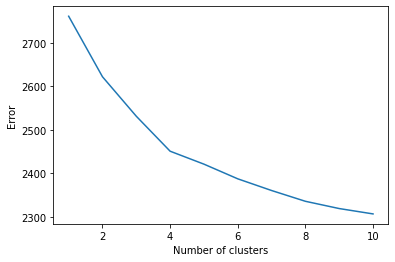

In [23]:
error = np.zeros(11)
sh_score = np.zeros(11)
for k in range(1,11):
    kmeans = sk_cluster.KMeans(init='k-means++', n_clusters=k, n_init=10)
    kmeans.fit_predict(data)
    error[k] = kmeans.inertia_
    if k>1: sh_score[k]= metrics.silhouette_score(data, kmeans.labels_)
plt.plot(range(1,len(error)),error[1:])
plt.xlabel('Number of clusters')
plt.ylabel('Error')

We see a peak at k = 4,k=5,k=6,k=7 (small peak),k=8 and k = 9 indicating that these may be good values for the cluster number. As the peak is largest at k=4, we will choose this number of clusters. 


Text(0, 0.5, 'silhouette score')

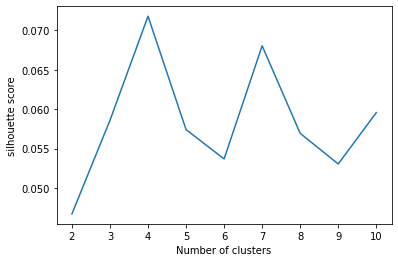

In [24]:
plt.plot(range(2,len(sh_score)),sh_score[2:])
plt.xlabel('Number of clusters')
plt.ylabel('silhouette score')

We will cluster with K-Means using k = 4 clusters instead of k = 3 as it has high silhouette score and low SSE.

In [29]:
X, true_labels = sk_data.make_blobs(n_samples=3008, centers=4, n_features=2,
center_box=(-10.0, 10.0),random_state=0)

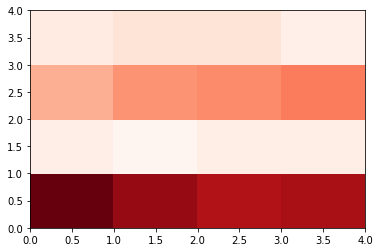

In [30]:
k=4
kmeans = sk_cluster.KMeans(n_clusters=k, init='k-means++', max_iter=100,n_init=1)
kmeans.fit_predict(data)
C = metrics.confusion_matrix(kmeans.labels_,true_labels)
plt.pcolormesh(C,cmap=plt.cm.Reds)

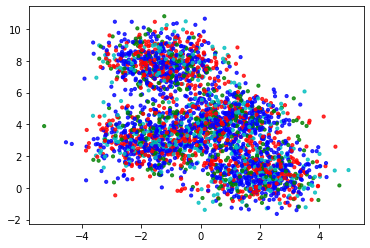

In [31]:
plt.scatter(X[:, 0], X[:, 1], color=colors[kmeans.labels_].tolist(), s=10,alpha=0.8)

Calculating the metrics again so we can compare with our original k=3 clustering.

In [32]:
p = metrics.precision_score(true_labels,kmeans.labels_, average=None)
print(p)
r = metrics.recall_score(true_labels,kmeans.labels_, average = None)
print(r) 

[0.26890756 0.23165138 0.25736236 0.22821577]
[0.46808511 0.13430851 0.26728723 0.1462766 ]


#### 3.

We will now try to evaluate our initial k-means results and try to find why some errors occur.

In [37]:
print("Top terms per cluster:")
asc_order_centroids = kmeans1.cluster_centers_.argsort()#[:, ::-1]
order_centroids = asc_order_centroids[:,::-1]
terms = v.get_feature_names()
for i in range(3):
    print ("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print (' %s' % terms[ind])
    print

Top terms per cluster:
Cluster 0:
 hair
 nails
 salon
 nail
 cut
 shellac
 manicure
 haircut
 stylist
 pedicure
Cluster 1:
 store
 massage
 shop
 customer
 bike
 buy
 selection
 location
 stores
 items
Cluster 2:
 food
 bar
 menu
 beer
 drinks
 ordered
 restaurant
 chicken
 night
 patio


We can see that there is the word "massage"  in Cluster 1 that is used for the "Shopping" category. "massage" correlates to the category of "Beauty&Spa" so this means that there are some businesses that are merged into a wrong cluster.

In [76]:
labels = kmeans1.labels_

In [41]:
import random

We will choose 10 random businesses from cluster 0 and 1 and examine their category. 

In [77]:
cluster0 = []
cluster1 = []
count = 0
while(count<10):
    x = random.randint(0,3007)
    if((labels[x] == 0) and (x not in cluster0)):
        cluster0.append(x)
        count += 1
count = 0
while(count<10):
    x = random.randint(0,3007)
    if((labels[x] == 1) and (x not in cluster1)):
        cluster1.append(x)
        count += 1

In [78]:
cluster0,cluster1

([1734, 2497, 216, 108, 2163, 1230, 2115, 2142, 1012, 2378],
 [2064, 2304, 2409, 895, 214, 2439, 2056, 1232, 212, 2566])

In [79]:
for i in cluster0:
    print(df.loc[i])

business_id                               aTG2L01L2VJgZSETk70-SQ
categories                                         Beauty & Spas
review         Everything I have read about the salon, and th...
Name: 1734, dtype: object
business_id                               U6Xg4m-nCFnf0QpFjfAIKQ
categories                                         Beauty & Spas
review         i came to civello to change my hair from brown...
Name: 2497, dtype: object
business_id                               g9g0fLPzznUeAXt-B626oQ
categories                                         Beauty & Spas
review         My stylist retired after being together for 20...
Name: 216, dtype: object
business_id                               qYSmTAjoe2MwXMvV7wANGQ
categories                                         Beauty & Spas
review         My wife and I both got haircuts from Shamim to...
Name: 108, dtype: object
business_id                               qwtApMzExpNIZJgKF7faCg
categories                                         Be

In [80]:
for i in cluster1:
    print(df.loc[i])

business_id                               e-aSY_ggUWmnYjR3rYQGlA
categories                                         Beauty & Spas
review         All I can say is the amazing artist Tegan, tra...
Name: 2064, dtype: object
business_id                               aIZwQGfgdoS_an1mp16yFw
categories                                              Shopping
review         You were there when I needed you LCBO..and for...
Name: 2304, dtype: object
business_id                               tjMcxAVvQZS1syoM9lZ1QA
categories                                         Beauty & Spas
review         Grassroots is fantastic.I love their bulk sale...
Name: 2409, dtype: object
business_id                               sXhnYJ_J6j0XfpMdpxiSFA
categories                                              Shopping
review         Good utility clothes.  It's similar to Gap, bu...
Name: 895, dtype: object
business_id                               EjZYT46Y2qHSoChynd0q-A
categories                                          

We can see that Shopping and Beauty&Spa are often mixed in the same category in cluster1. Maybe due to common keywords such as "sale" and other "Shopping related ones"

For the new clustering that we did:

In [81]:
print("Top terms per cluster:")
asc_order_centroids = kmeans.cluster_centers_.argsort()#[:, ::-1]
order_centroids = asc_order_centroids[:,::-1]
terms = v.get_feature_names()
for i in range(k):
    print ("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print (' %s' % terms[ind])
    print

Top terms per cluster:
Cluster 0:
 store
 massage
 shop
 customer
 bike
 buy
 location
 selection
 stores
 products
Cluster 1:
 food
 beer
 pub
 bar
 wings
 burger
 fries
 patio
 menu
 drinks
Cluster 2:
 food
 bar
 menu
 restaurant
 drinks
 ordered
 chicken
 night
 delicious
 table
Cluster 3:
 hair
 nails
 salon
 nail
 cut
 shellac
 manicure
 haircut
 stylist
 pedicure


In [82]:
kmeans.cluster_centers_

array([[3.01276678e-03, 1.67431872e-03, 1.55248229e-04, ...,
        1.89868672e-04, 5.15694587e-05, 0.00000000e+00],
       [4.73436976e-03, 4.08202179e-04, 2.11370094e-04, ...,
        2.35281773e-04, 1.17750526e-04, 6.36992613e-06],
       [3.90373247e-03, 4.09520242e-04, 5.15766119e-04, ...,
        1.46664001e-04, 7.57108833e-05, 5.17200088e-05],
       [4.24948010e-03, 1.78486308e-04, 2.74701123e-05, ...,
        0.00000000e+00, 3.23598368e-05, 0.00000000e+00]])

We can see that the shopping (food etc.) cluster was split into 2 and the Beauty cluster into its separate one.

We will again choose 10 businesses from each cluster and check their categories.

In [91]:
labels = kmeans.labels_
cluster0 = []
cluster1 = []
cluster2 = []
cluster3 = []

count = 0
while(count<10):
    x = random.randint(0,3007)
    if((labels[x] == 0) and (x not in cluster0)):
        cluster0.append(x)
        count += 1
count = 0
while(count<10):
    x = random.randint(0,3007)
    if((labels[x] == 1) and (x not in cluster1)):
        cluster1.append(x)
        count += 1
count = 0
while(count<10):
    x = random.randint(0,3007)
    if((labels[x] == 2) and (x not in cluster2)):
        cluster2.append(x)
        count += 1
count = 0
while(count<10):
    x = random.randint(0,3007)
    if((labels[x] == 3) and (x not in cluster3)):
        cluster3.append(x)
        count += 1

In [92]:
for i in cluster0:
    print(df.loc[i])

business_id                               lkR0BP2MziVYUdPUEvl7QA
categories                                              Shopping
review         I love many things. But it's a rare find to ha...
Name: 2566, dtype: object
business_id                               eI2o_IzeqT4mgE-8MxRjvQ
categories                                              Shopping
review         Social Butterfly carries a mish mash of almost...
Name: 2828, dtype: object
business_id                               cS7RpQt0MAUlcheCGo3iXw
categories                                              Shopping
review         These guys are great; they rescued me when my ...
Name: 111, dtype: object
business_id                               3DTfc6rVaCrxVm0mbSgBBw
categories                                              Shopping
review         Out of stock on sale items always. Surly staff...
Name: 2507, dtype: object
business_id                               FXhR0kbJq5Hemeh_A0LeXQ
categories                                         B

In [93]:
for i in cluster1:
    print(df.loc[i])

business_id                               K6XIGkyk7-fuOQtA8i7p6A
categories                                                  Bars
review         I stopped here for an impromptu lunch on a spo...
Name: 636, dtype: object
business_id                               ZpPOiNYi4AHNneI7uco7GQ
categories                                                  Bars
review         Just awful. I had the money chicken sandwich, ...
Name: 42, dtype: object
business_id                               UdBOTGSbC6VOhUg6l9OwXA
categories                                                  Bars
review         That's a great place, have good food and darts...
Name: 827, dtype: object
business_id                               73_UT7fZ7mzXcguX8-oSuQ
categories                                                  Bars
review         Fantastic food at reasonable prices, great vie...
Name: 1937, dtype: object
business_id                               qPkyjuQyKMrHkbs2pGg7PQ
categories                                             

In [94]:
for i in cluster2:
    print(df.loc[i])

business_id                               GKEl7LNGUqJiQWNQ0vpH8Q
categories                                                  Bars
review         I've been to this Milestones a few times (thin...
Name: 360, dtype: object
business_id                               mQuDZwxxPe54MY4TT8lEPQ
categories                                                  Bars
review         My friend and I ordered the famous fried chick...
Name: 1739, dtype: object
business_id                               t_XpjR3_Cf7r9tj3w3vAbw
categories                                                  Bars
review         Outstanding from start to finish.  I ordered t...
Name: 1331, dtype: object
business_id                               XxDjuiNzGxBiTasXOEx13g
categories                                                  Bars
review         The food was decent but the service was very v...
Name: 2858, dtype: object
business_id                               dqXWQSaNMKf9fimx_AT31w
categories                                          

In [95]:
for i in cluster3:
    print(df.loc[i])

business_id                               uw0wyepDhMFAwamyvPC61A
categories                                         Beauty & Spas
review         Most welcoming hair salon I've been to. The fi...
Name: 521, dtype: object
business_id                               m0O-T3Fchb8oLiqy73x1yg
categories                                         Beauty & Spas
review         Rushing to Mexico the following day I needed h...
Name: 1050, dtype: object
business_id                               pzFep53lytdR7mZmdXEOZw
categories                                         Beauty & Spas
review         Came here today for my first time and I am qui...
Name: 1994, dtype: object
business_id                               MiUPskSaKQHLZlrmbQtv7Q
categories                                         Beauty & Spas
review         Before leaving for vacation I got a shellac ma...
Name: 292, dtype: object
business_id                               PUH6mMtltSVhA1yssiWqCw
categories                                         Be

From the above we cann see that Beauty&Spas are merged into cluster3 and some of them still being in cluster0. Bars are in cluster1 and cluster3. Shopping are only in cluster0. Maybe if we clustered with k>4, we could again split Shopping and Beauty&Spas.

In [99]:
centroids  = kmeans.cluster_centers_  #means of shape [10,] 
centroid_labels = [centroids[i] for i in labels]